# Uniform

# Constant step size

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
-147.61


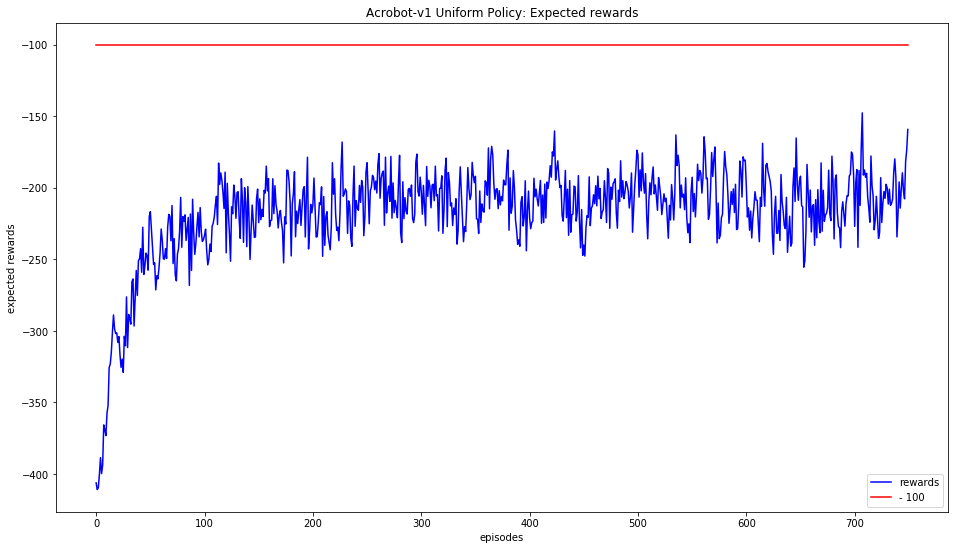

In [3]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
env = gym.make('Acrobot-v1')
#n_actions = env.action_space.n
#n_states = env.observation_space.shape[0]
#print("Action space size: ", n_actions)
#print("State space size: ", n_states)
#print('states high value:')
#print(env.observation_space.high[0]) # 1  cos of first rotational joint 
#print(env.observation_space.high[1])  # 1 sin of first rotational joint
#print(env.observation_space.high[2])  # 1 cos of first rotational joint
#print(env.observation_space.high[3])  # 1 sin of first rotational joint
#print(env.observation_space.high[4])  # 12.566371 angular velocity of 1st joint
#print(env.observation_space.high[5])  # 28.274334 angular velocity of 2nd joint

#print('states low value:')
#print(env.observation_space.low[0])   #-4.8
#print(env.observation_space.low[1])  #-3.4028235e+38
#print(env.observation_space.low[2])  #-0.41887903
#print(env.observation_space.low[3])  #-3.4028235e+38
#print(env.observation_space.low[4])
#print(env.observation_space.low[5])
#[cos(theta1), sin(theta1), cos(theta2), sin(theta2), theta_dot1, theta_dot2]

#Acrobot does not have threshold at which it is considered solved.
'''This environment consists of a two link, two joint robot.
The joint between the links is actuated. At the start of the episode,
the links are hanging downwards. At every timestep the agent chooses
an action that correspond to applying a force to move the actuated
link to the right, to the left, or to not applying a force.
The episode is over once the end of the lower link swings above a certain
height.The goal is to end the episode in the fewest possible timesteps.
We use the OpenAI Gym ‘Acrobot-v1’ environment. This implementation is
based on the system presented in (Geram- ifard et al., 2015).
Each observation is a set consisting of readings from six sensors,
corresponding to the rotational joint angles and velocities of joints and links.
The action space is discrete with three elements, and at each timestep
the environment returns the observation and a reward of -1. 
An episode is terminated after 200 time steps irrespective of
the state of the robot. This is an unsolved environment,
which means it does not have a specified reward threshold at which
it’s considered solved.'''

#(1, 1, 1, 1, 12, 13)
class Qlearning():  #change the buckets #(self,bins=(1, 1, 1, 1, 12, 24) #(1,1,3,3,6,12) #(2, 2, 2, 2, 8, 12)
    def __init__(self,bins=(1, 1, 1, 1, 6, 13), max_episodes = 1500, max_steps = 500, min_alpha=0.1, min_epsilon=0.0, gamma = 1.0, epsilon = 1.0, decay = 25, action_space = env.action_space.n, env = gym.make('Acrobot-v1')):   #max_env_steps=None
        #(1, 1, 1, 1, 6, 11)
        self.bins = bins 
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.min_alpha = min_alpha  #step size
        self.min_epsilon = min_epsilon #
        self.epsilon = epsilon
        self.gamma = gamma  # discount factor
        self.decay = decay
        self.action_space = action_space
        self.env = env
        self.QTable = np.zeros((self.bins + (self.action_space,))) #The Q LookUp Table --> its dimension is  (1 x 1 x 6 x 12 x 2)
        self.alpha = 1 # learning rate
        self.beta = 0.5

    def discretize(self, state):
        upper_bounds = [1.0, 1.0, 1.0, 1.0, env.observation_space.high[4], env.observation_space.high[5]]  
        lower_bounds = [-1.0,-1.0,-1.0,-1.0, env.observation_space.low[4], env.observation_space.low[5]]
        descretizedList = list()
        for i in  range(len(state)): 
            ratios = (state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) 
            new_obs = int(round((self.bins[i] - 1) * ratios)) 
            new_obs = min(self.bins[i] - 1, max(0, new_obs))
            descretizedList.append(new_obs)
        return tuple(descretizedList)


    def action(self, state, epsilon):
        ''' choose an action using the epsilon policy '''
        action = self.env.action_space.sample()   
        return action

    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        # self.QTable[old_state][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
        return
    
    def decay_epsilon(self):
        epsilon = self.epsilon - 0.001
        if epsilon < self.min_epsilon:
            self.epsilon = self.min_epsilon
        else:
            self.epsilon = epsilon
        return epsilon

    def decay_step_size(self, t):
        if t == 0:
            step_size = 1.0
        elif t > 0:
            step_size = self.alpha / (t ** self.beta)  
        return step_size
    
    def action_policy(self, state, policy):
        return policy[state]
    
#1-ln(time unit/decay)
def learning(Qlearning):
    rewards = []
    alphaList = []
    epsilonList = []
    for e in range(Qlearning.max_episodes):  
        state = Qlearning.discretize(env.reset())
        epsilon = Qlearning.decay_epsilon()
        step_size = 0.01 
        i = 0
        for t in range(Qlearning.max_steps):
            if e % 2 == 0:
                action = Qlearning.action(state, epsilon)
            if e % 2 ==1:
                action = Qlearning.action_policy(state, policy)
            new_state, reward, done, info = env.step(action)
            new_state = Qlearning.discretize(new_state)
            Qlearning.Q_Update(state, action, reward, new_state, step_size)
            state = new_state
            i += reward 
            if done:
                break
        ########### Policy Extraction ##########
        stateTuple = list()
        stateList = []
        actionsList = []
        states = []
        for list1 in Qlearning.QTable:
            for nextList in list1:
                for nextList1 in nextList: 
                    for nextList2 in nextList1:
                        for nextList3 in nextList2:
                            for nextList4 in nextList3:
                                actions = np.argmax(nextList4)
                                actionsList.append(actions)
        observations = np.argwhere(Qlearning.QTable>=-500)
        j = 0
        for obsList in observations:
            stateTuple = (obsList[0], obsList[1], obsList[2], obsList[3], obsList[4], obsList[5])
            stateList.append(stateTuple)
        del stateList[1::3] 
        del stateList[1::2]
        policy = dict(zip(stateList, actionsList))
        if e % 2 == 1:
            rewards.append(i)
            alphaList.append(step_size)
            epsilonList.append(epsilon)
            mean_rewards =  np.mean(rewards)
    return rewards, alphaList, epsilonList



if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    solve = Qlearning()
    #rewards, alpha, epsilon= solve.learning()
    listof_100 = []
    trajectory = []
    #print(max(rewards))
    for i in range(100):
        solve = Qlearning()
        rewards, alpha, epsilon = learning(solve)
        trajectory.append(rewards)
        #print(rewards)
        #print("alpha", alpha)
        print(i)
    for episode in rewards:
        listof_100.append(-1*100)
    a = np.array(trajectory)
    final = np.mean(a, axis=0)
    meanRewards = []
    print(max(final))
    #moving_ave = solve.moving_average(final)
    fig = plt.figure(figsize=(16,9))

    plt1 = fig.add_subplot(111)
    plt1.plot(final,  # epsilon_hist,
             color='b',
             label='rewards')
    plt1.plot(listof_100,
             color = 'red',
             label = "- 100")
    plt1.set(title='Acrobot-v1 Uniform Policy: Expected rewards',
            ylabel='expected rewards',
            xlabel='episodes')
    plt1.legend(loc='best')
    plt.show()

# Continually Diminishing Step Size

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
-82.42


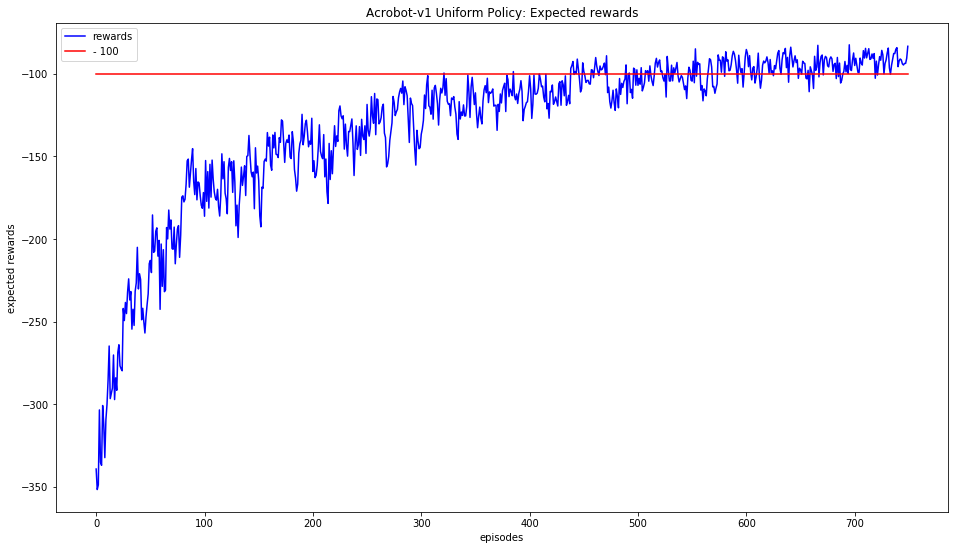

In [1]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
env = gym.make('Acrobot-v1')
#n_actions = env.action_space.n
#n_states = env.observation_space.shape[0]
#print("Action space size: ", n_actions)
#print("State space size: ", n_states)
#print('states high value:')
#print(env.observation_space.high[0]) # 1  cos of first rotational joint 
#print(env.observation_space.high[1])  # 1 sin of first rotational joint
#print(env.observation_space.high[2])  # 1 cos of first rotational joint
#print(env.observation_space.high[3])  # 1 sin of first rotational joint
#print(env.observation_space.high[4])  # 12.566371 angular velocity of 1st joint
#print(env.observation_space.high[5])  # 28.274334 angular velocity of 2nd joint

#print('states low value:')
#print(env.observation_space.low[0])   #-4.8
#print(env.observation_space.low[1])  #-3.4028235e+38
#print(env.observation_space.low[2])  #-0.41887903
#print(env.observation_space.low[3])  #-3.4028235e+38
#print(env.observation_space.low[4])
#print(env.observation_space.low[5])
#[cos(theta1), sin(theta1), cos(theta2), sin(theta2), theta_dot1, theta_dot2]

#Acrobot does not have threshold at which it is considered solved.
'''This environment consists of a two link, two joint robot.
The joint between the links is actuated. At the start of the episode,
the links are hanging downwards. At every timestep the agent chooses
an action that correspond to applying a force to move the actuated
link to the right, to the left, or to not applying a force.
The episode is over once the end of the lower link swings above a certain
height.The goal is to end the episode in the fewest possible timesteps.
We use the OpenAI Gym ‘Acrobot-v1’ environment. This implementation is
based on the system presented in (Geram- ifard et al., 2015).
Each observation is a set consisting of readings from six sensors,
corresponding to the rotational joint angles and velocities of joints and links.
The action space is discrete with three elements, and at each timestep
the environment returns the observation and a reward of -1. 
An episode is terminated after 200 time steps irrespective of
the state of the robot. This is an unsolved environment,
which means it does not have a specified reward threshold at which
it’s considered solved.'''

#(1, 1, 1, 1, 12, 13)
class Qlearning():  #change the buckets #(self,bins=(1, 1, 1, 1, 12, 24) #(1,1,3,3,6,12) #(2, 2, 2, 2, 8, 12)
    def __init__(self,bins=(1, 1, 1, 1, 6, 13), max_episodes = 1500, max_steps = 500, min_alpha=0.1, min_epsilon=0.0, gamma = 1.0, epsilon = 1.0, decay = 25, action_space = env.action_space.n, env = gym.make('Acrobot-v1')):   #max_env_steps=None
        #(1, 1, 1, 1, 6, 11)
        self.bins = bins 
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.min_alpha = min_alpha  #step size
        self.min_epsilon = min_epsilon #
        self.epsilon = epsilon
        self.gamma = gamma  # discount factor
        self.decay = decay
        self.action_space = action_space
        self.env = env
        self.QTable = np.zeros((self.bins + (self.action_space,))) #The Q LookUp Table --> its dimension is  (1 x 1 x 6 x 12 x 2)
        self.alpha = 1 # learning rate
        self.beta = 0.5

    def discretize(self, state):
        upper_bounds = [1.0, 1.0, 1.0, 1.0, env.observation_space.high[4], env.observation_space.high[5]]  
        lower_bounds = [-1.0,-1.0,-1.0,-1.0, env.observation_space.low[4], env.observation_space.low[5]]
        descretizedList = list()
        for i in  range(len(state)): 
            ratios = (state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) 
            new_obs = int(round((self.bins[i] - 1) * ratios)) 
            new_obs = min(self.bins[i] - 1, max(0, new_obs))
            descretizedList.append(new_obs)
        return tuple(descretizedList)


    def action(self, state, epsilon):
        ''' choose an action using the epsilon policy '''
        action = self.env.action_space.sample()   
        return action

    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        # self.QTable[old_state][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
        return
    
    def decay_epsilon(self):
        epsilon = self.epsilon - 0.001
        if epsilon < self.min_epsilon:
            self.epsilon = self.min_epsilon
        else:
            self.epsilon = epsilon
        return epsilon

    def decay_step_size(self, tt, e, t):
        num = self.alpha
        dem = tt**self.beta
        if e == 0 and t == 0:
            step_size = 1
        elif tt > 0:
            step_size = num / dem
        return step_size
    
    def action_policy(self, state, policy):
        return policy[state]

    
#1-ln(time unit/decay)
def learning(Qlearning):
    rewards = []
    alphaList = []
    epsilonList = []
    tt = 0
    for e in range(Qlearning.max_episodes):  
        state = Qlearning.discretize(env.reset())
        epsilon = Qlearning.decay_epsilon()
        i = 0
        for t in range(Qlearning.max_steps):
            step_size = Qlearning.decay_step_size(tt,e,t)
            tt+=1
            if e % 2 == 0:
                action = Qlearning.action(state, epsilon)
            if e % 2 ==1:
                action = Qlearning.action_policy(state, policy)
            new_state, reward, done, info = env.step(action)
            new_state = Qlearning.discretize(new_state)
            Qlearning.Q_Update(state, action, reward, new_state, step_size)
            state = new_state
            i += reward 
            if done:
                break
        ########### Policy Extraction ##########
        stateTuple = list()
        stateList = []
        actionsList = []
        states = []
        for list1 in Qlearning.QTable:
            for nextList in list1:
                for nextList1 in nextList: 
                    for nextList2 in nextList1:
                        for nextList3 in nextList2:
                            for nextList4 in nextList3:
                                actions = np.argmax(nextList4)
                                actionsList.append(actions)
        observations = np.argwhere(Qlearning.QTable>=-500)
        j = 0
        for obsList in observations:
            stateTuple = (obsList[0], obsList[1], obsList[2], obsList[3], obsList[4], obsList[5])
            stateList.append(stateTuple)
        del stateList[1::3] 
        del stateList[1::2]
        policy = dict(zip(stateList, actionsList))
        if e % 2 == 1:
            rewards.append(i)
            alphaList.append(step_size)
            epsilonList.append(epsilon)
            mean_rewards =  np.mean(rewards)
    return rewards, alphaList, epsilonList



if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    solve = Qlearning()
    #rewards, alpha, epsilon= solve.learning()
    listof_100 = []
    trajectory = []
    #print(max(rewards))
    for i in range(100):
        solve = Qlearning()
        rewards, alpha, epsilon = learning(solve)
        trajectory.append(rewards)
        #print(rewards)
        #print("alpha", alpha)
        print(i)
    for episode in rewards:
        listof_100.append(-1*100)
    a = np.array(trajectory)
    final = np.mean(a, axis=0)
    meanRewards = []
    print(max(final))
    #moving_ave = solve.moving_average(final)
    fig = plt.figure(figsize=(16,9))

    plt1 = fig.add_subplot(111)
    plt1.plot(final,  # epsilon_hist,
             color='b',
             label='rewards')
    plt1.plot(listof_100,
             color = 'red',
             label = "- 100")
    plt1.set(title='Acrobot-v1 Uniform Policy: Expected rewards',
            ylabel='expected rewards',
            xlabel='episodes')
    plt1.legend(loc='best')
    plt.show()

# Restarting Diminishing

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
-236.46


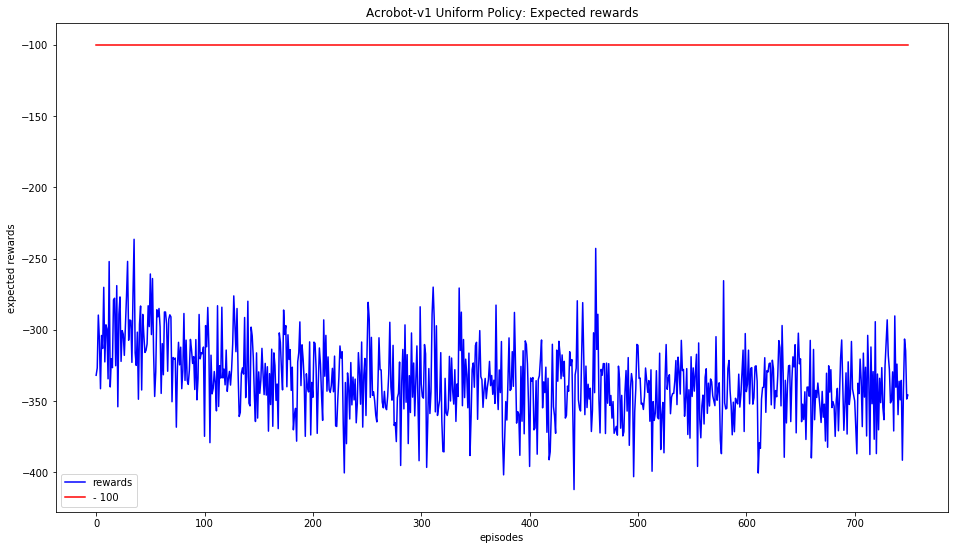

In [3]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
env = gym.make('Acrobot-v1')
#n_actions = env.action_space.n
#n_states = env.observation_space.shape[0]
#print("Action space size: ", n_actions)
#print("State space size: ", n_states)
#print('states high value:')
#print(env.observation_space.high[0]) # 1  cos of first rotational joint 
#print(env.observation_space.high[1])  # 1 sin of first rotational joint
#print(env.observation_space.high[2])  # 1 cos of first rotational joint
#print(env.observation_space.high[3])  # 1 sin of first rotational joint
#print(env.observation_space.high[4])  # 12.566371 angular velocity of 1st joint
#print(env.observation_space.high[5])  # 28.274334 angular velocity of 2nd joint

#print('states low value:')
#print(env.observation_space.low[0])   #-4.8
#print(env.observation_space.low[1])  #-3.4028235e+38
#print(env.observation_space.low[2])  #-0.41887903
#print(env.observation_space.low[3])  #-3.4028235e+38
#print(env.observation_space.low[4])
#print(env.observation_space.low[5])
#[cos(theta1), sin(theta1), cos(theta2), sin(theta2), theta_dot1, theta_dot2]

#Acrobot does not have threshold at which it is considered solved.
'''This environment consists of a two link, two joint robot.
The joint between the links is actuated. At the start of the episode,
the links are hanging downwards. At every timestep the agent chooses
an action that correspond to applying a force to move the actuated
link to the right, to the left, or to not applying a force.
The episode is over once the end of the lower link swings above a certain
height.The goal is to end the episode in the fewest possible timesteps.
We use the OpenAI Gym ‘Acrobot-v1’ environment. This implementation is
based on the system presented in (Geram- ifard et al., 2015).
Each observation is a set consisting of readings from six sensors,
corresponding to the rotational joint angles and velocities of joints and links.
The action space is discrete with three elements, and at each timestep
the environment returns the observation and a reward of -1. 
An episode is terminated after 200 time steps irrespective of
the state of the robot. This is an unsolved environment,
which means it does not have a specified reward threshold at which
it’s considered solved.'''

#(1, 1, 1, 1, 12, 13)
class Qlearning():  #change the buckets #(self,bins=(1, 1, 1, 1, 12, 24) #(1,1,3,3,6,12) #(2, 2, 2, 2, 8, 12)
    def __init__(self,bins=(1, 1, 1, 1, 6, 13), max_episodes = 1500, max_steps = 500, min_alpha=0.1, min_epsilon=0.0, gamma = 1.0, epsilon = 1.0, decay = 25, action_space = env.action_space.n, env = gym.make('Acrobot-v1')):   #max_env_steps=None
        #(1, 1, 1, 1, 6, 11)
        self.bins = bins 
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.min_alpha = min_alpha  #step size
        self.min_epsilon = min_epsilon #
        self.epsilon = epsilon
        self.gamma = gamma  # discount factor
        self.decay = decay
        self.action_space = action_space
        self.env = env
        self.QTable = np.zeros((self.bins + (self.action_space,))) #The Q LookUp Table --> its dimension is  (1 x 1 x 6 x 12 x 2)
        self.alpha = 1 # learning rate
        self.beta = 0.5

    def discretize(self, state):
        upper_bounds = [1.0, 1.0, 1.0, 1.0, env.observation_space.high[4], env.observation_space.high[5]]  
        lower_bounds = [-1.0,-1.0,-1.0,-1.0, env.observation_space.low[4], env.observation_space.low[5]]
        descretizedList = list()
        for i in  range(len(state)): 
            ratios = (state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) 
            new_obs = int(round((self.bins[i] - 1) * ratios)) 
            new_obs = min(self.bins[i] - 1, max(0, new_obs))
            descretizedList.append(new_obs)
        return tuple(descretizedList)


    def action(self, state, epsilon):
        ''' choose an action using the epsilon policy '''
        action = self.env.action_space.sample()   
        return action

    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        # self.QTable[old_state][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
        return
    
    def decay_epsilon(self):
        epsilon = self.epsilon - 0.001
        if epsilon < self.min_epsilon:
            self.epsilon = self.min_epsilon
        else:
            self.epsilon = epsilon
        return epsilon

    def decay_step_size(self, t):
        if t == 0:
            step_size = 1.0
        elif t > 0:
            step_size = self.alpha / (t ** self.beta)  
        return step_size
    
    def action_policy(self, state, policy):
        return policy[state]

    
#1-ln(time unit/decay)
def learning(Qlearning):
    rewards = []
    alphaList = []
    epsilonList = []
    tt = 0
    for e in range(Qlearning.max_episodes):  
        state = Qlearning.discretize(env.reset())
        epsilon = Qlearning.decay_epsilon()
        step_size = 1 #0.01 
        i = 0
        for t in range(Qlearning.max_steps):
            step_size = Qlearning.decay_step_size(t)
            tt+=1
            if e % 2 == 0:
                action = Qlearning.action(state, epsilon)
            if e % 2 ==1:
                action = Qlearning.action_policy(state, policy)
            new_state, reward, done, info = env.step(action)
            new_state = Qlearning.discretize(new_state)
            Qlearning.Q_Update(state, action, reward, new_state, step_size)
            state = new_state
            i += reward 
            if done:
                break
        ########### Policy Extraction ##########
        stateTuple = list()
        stateList = []
        actionsList = []
        states = []
        for list1 in Qlearning.QTable:
            for nextList in list1:
                for nextList1 in nextList: 
                    for nextList2 in nextList1:
                        for nextList3 in nextList2:
                            for nextList4 in nextList3:
                                actions = np.argmax(nextList4)
                                actionsList.append(actions)
        observations = np.argwhere(Qlearning.QTable>=-10000)
        j = 0
        for obsList in observations:
            stateTuple = (obsList[0], obsList[1], obsList[2], obsList[3], obsList[4], obsList[5])
            stateList.append(stateTuple)
        del stateList[1::3] 
        del stateList[1::2]
        policy = dict(zip(stateList, actionsList))
        if e % 2 == 1:
            rewards.append(i)
            alphaList.append(step_size)
            epsilonList.append(epsilon)
            mean_rewards =  np.mean(rewards)
    return rewards, alphaList, epsilonList



if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    solve = Qlearning()
    #rewards, alpha, epsilon= solve.learning()
    listof_100 = []
    trajectory = []
    #print(max(rewards))
    for i in range(50):
        solve = Qlearning()
        rewards, alpha, epsilon = learning(solve)
        trajectory.append(rewards)
        #print(rewards)
        #print("alpha", alpha)
        print(i)
    for episode in rewards:
        listof_100.append(-1*100)
    a = np.array(trajectory)
    final = np.mean(a, axis=0)
    meanRewards = []
    print(max(final))
    #moving_ave = solve.moving_average(final)
    fig = plt.figure(figsize=(16,9))

    plt1 = fig.add_subplot(111)
    plt1.plot(final,  # epsilon_hist,
             color='b',
             label='rewards')
    plt1.plot(listof_100,
             color = 'red',
             label = "- 100")
    plt1.set(title='Acrobot-v1 Uniform Policy: Expected rewards',
            ylabel='expected rewards',
            xlabel='episodes')
    plt1.legend(loc='best')
    plt.show()

In [ ]:
50